In [6]:
import  torch

model = torch.load("../models/neuralforecast_models/AutoAutoformer_0.ckpt")
# 获取权重
Wq = model['state_dict']['encoder.attn_layers.1.attention.query_projection.weight'].data
Wk = model['state_dict']['encoder.attn_layers.1.attention.key_projection.weight'].data
Wv = model['state_dict']['encoder.attn_layers.1.attention.value_projection.weight'].data

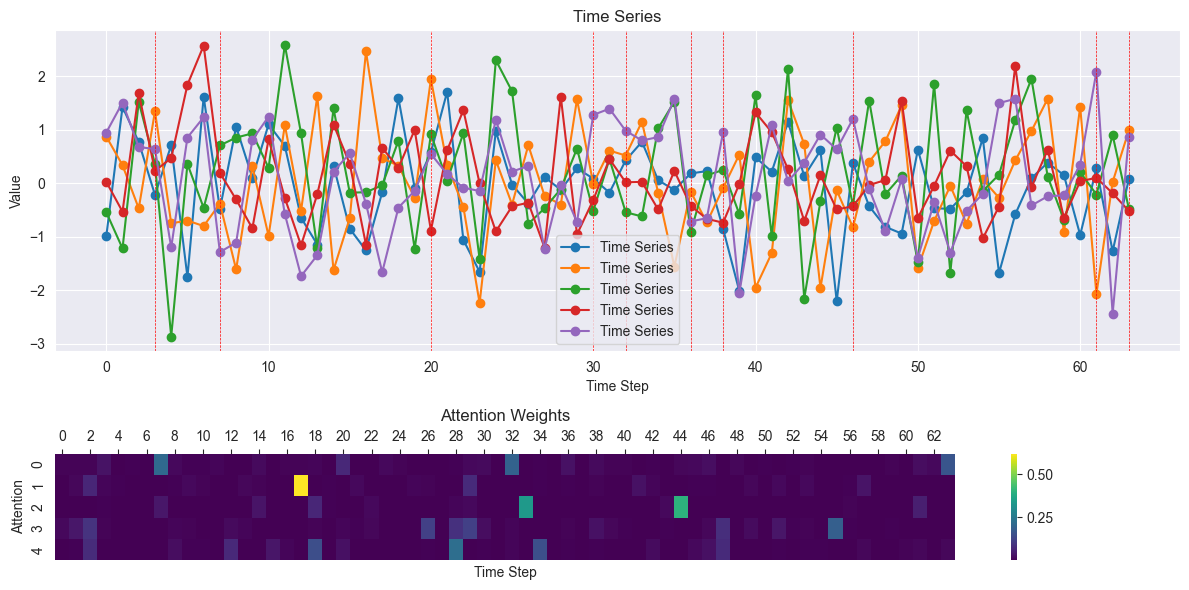

In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def autocorrelation(query_states, key_states):
    query_states_fft = torch.fft.rfft(query_states, dim=1)
    key_states_fft = torch.fft.rfft(key_states, dim=1)
    attn_weights = query_states_fft * torch.conj(key_states_fft)
    attn_weights = torch.fft.irfft(attn_weights, dim=1)
    return attn_weights.real

def compute_attention(time_series, Wq, Wk, Wv,top_k=6):
    Q = torch.matmul(time_series, Wq)
    K = torch.matmul(time_series, Wk)
    V = torch.matmul(time_series, Wv)

    attention_scores = autocorrelation(Q, K)
    attention_weights = F.softmax(attention_scores, dim=-1)  # Apply softmax to normalize

    # Setup the plot
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]})
    
    # Time series plot
    axs[0].plot(time_series.T, 'o-', label='Time Series')
    axs[0].set_title('Time Series')
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    
    top_attention, top_indices = torch.topk(attention_weights, top_k, dim=1)  # Get top-k attention scores and indices
    for idx in top_indices[0]:  # Assuming single batch; adjust if multiple batches
        axs[0].axvline(x=idx.item(), color='r', linestyle='--', lw=0.5, label=f'High Attention (Step {idx.item()})')


    # Attention weights heatmap
    sns.heatmap(attention_weights, ax=axs[1], cmap='viridis', cbar=True)
    axs[1].set_title('Attention Weights')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Attention')
    axs[1].xaxis.set_ticks_position('top')  # Move x-axis to top to align with time series plot

    plt.tight_layout()
    plt.show()

    return attention_weights

# Initialize weights and time series
d_model = 64
time_series_length = 5
time_series = torch.randn(time_series_length, d_model)

# Compute and visualize attention
attention_weights = compute_attention(time_series, Wq, Wk, Wv,10)
